In [118]:
%matplotlib inline
# %matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA # Principle Component Analysis
from sklearn.cluster import AgglomerativeClustering # hierarchical agglomerative clustering
from sklearn.cluster import KMeans # k-means
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score #model evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix #model evaluation
from sklearn.metrics import silhouette_score


from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.mixture import GaussianMixture # EM/GMM
from sklearn.utils import shuffle

import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

from mizani.breaks import date_breaks
from mizani.formatters import date_format

pd.set_option('display.max_rows', 100)



np.random.seed(11132009)

In [72]:
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib.colors import LinearSegmentedColormap

fpath = '../Personal Folders/Dan/futura_medium_condensed_bt.ttf'
futura = fm.FontProperties(fname=fpath)



FMF_Palette = ["#5C5C5C","#46ACC8","#E2D200","#DD8D29","#E58601","#B40F20"]
Cav_Palette = ["#D8B70A","#02401B","#A2A475","#81A88D","#972D15","#1B1B37"]
BRk_Palette = ["#FD8688","#CB2314","#FAD510","#5B7C3C","#3B4868","#1E1E1E"]

In [3]:
print(futura)

sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:file=../Personal Folders/Dan/futura\_medium\_condensed\_bt.ttf:size=10.0


## 1- What insights can we find by analyzing variable trends over the years?

In [4]:
data_1 = pd.read_csv("../Data/data_modified.csv")
data_1.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,explicit,key,mode,year,name,artists
0,0.995,0.514,172133,0.2560,0.00000,0.3490,-15.145,0,0.0871,79.467,0.574,0,0,1,1921,Si J'avais Su,['Alice Cocéa']
1,0.994,0.426,177733,0.2260,0.00000,0.2350,-16.126,0,0.0693,73.630,0.552,0,9,1,1921,Elle Porte Un Nom Charmant,['André Urban']
2,0.971,0.540,122000,0.0848,0.00196,0.0887,-16.055,0,0.0750,100.296,0.527,0,5,0,1921,A Ballynure Ballad,['Christopher Lynch']
3,0.950,0.607,163200,0.1380,0.00000,0.1140,-15.683,0,0.1570,113.282,0.511,0,3,1,1921,I Met Her In The Garden Where The Praties Grow,['Christopher Lynch']
4,0.969,0.344,120067,0.1310,0.00000,0.1450,-14.261,0,0.0616,178.212,0.257,0,10,0,1921,Just A Little Bit Of Heaven,['Christopher Lynch']


In [5]:
## DATA AGGREGATION ##

# CONTINUOUS VARIABLES #

cont_features_1 = ["acousticness", 
                   "danceability", 
                   "duration_ms", 
                   "energy", 
                   "instrumentalness", 
                   "liveness", 
                   "loudness", 
                   "popularity", 
                   "speechiness", 
                   "tempo", 
                   "valence"]
data_agg_cols_1 = ["year"] + cont_features_1
data_agg_1 = pd.DataFrame(columns = data_agg_cols_1)

# CATEGORICAL VARIABLES #

#Kyes
key_cols_1 = ["year", "key", "number", "percentage"]
key_distro_1 = pd.DataFrame(columns = key_cols_1)

#Mode
mode_cols_1 = ["year", "mode", "number", "percentage"]
mode_distro_1 = pd.DataFrame(columns = mode_cols_1)

#Explicit
explicit_cols_1 = ["year", "explicit", "number", "percentage"]
explicit_distro_1 = pd.DataFrame(columns = explicit_cols_1)

In [6]:
# Loop through each year
for i in range (1921, 2021):
    # Create a temporary dataframe for the year
    inYr = data_1["year"] == i
    yrDF = data_1.loc[inYr]
    
    ### CONTINUOUS VARIABLES ###
    
    data_agg_1 = data_agg_1.append(pd.DataFrame({"year" : [float(i)],
                                                 "acousticness": yrDF["acousticness"].mean(), 
                                                 "danceability": yrDF["danceability"].mean(), 
                                                 "duration_ms": yrDF["duration_ms"].mean(), 
                                                 "energy": yrDF["energy"].mean(), 
                                                 "instrumentalness": yrDF["instrumentalness"].mean(), 
                                                 "liveness": yrDF["liveness"].mean(), 
                                                 "loudness": yrDF["loudness"].mean(), 
                                                 "popularity": yrDF["popularity"].mean(), 
                                                 "speechiness": yrDF["speechiness"].mean(), 
                                                 "tempo": yrDF["tempo"].mean(), 
                                                 "valence": yrDF["valence"].mean()}))
    
    #### KYES ####
    
    # Count number of times each key is used in the year
    num_keys = np.array([0] * 12)
    
    for j in yrDF['key']:
        num_keys[j] = num_keys[j] + 1
    
    # Calculate percentage for each key
    percent_keys = num_keys / yrDF.shape[0]
    
    # Add each year/key pair to the key_distro_1 DF
    for j in range (0, 12):
        key_distro_1 = key_distro_1.append(pd.DataFrame({"year":[i],
                                                         "key": [j],
                                                         "number": [num_keys[j]],
                                                         "percentage": [percent_keys[j]]}))
        
    #### MODES ####
    
    # Count number of times each mode is used in the year
    num_modes = np.array([0] * 2)
    
    for j in yrDF['mode']:
        num_modes[j] = num_modes[j] + 1
    
    # Calculate percentage for each mode
    percent_modes = num_modes / yrDF.shape[0]
    
    # Add each year/mode pair to the mode_distro_1 DF
    for j in range (1, 2):
        mode_distro_1 = mode_distro_1.append(pd.DataFrame({"year":[i],
                                                           "mode": [j],
                                                           "number": [num_modes[j]],
                                                           "percentage": [percent_modes[j]]}))
        
    #### EXPLICIT ####
    
    # Count number of times a song is explicit or not
    num_explicit = np.array([0] * 2)
    
    for j in yrDF['explicit']:
        num_explicit[j] = num_explicit[j] + 1
    
    # Calculate percentage per year a song is explicit
    percent_explicit = num_explicit / yrDF.shape[0]
    
    # Add each year/explicit pair to the explicit_distro_1 DF
    for j in range (0, 1):
        explicit_distro_1 = explicit_distro_1.append(pd.DataFrame({"year":[i],
                                                           "explicit": [j],
                                                           "number": [num_explicit[j]],
                                                           "percentage": [percent_explicit[j]]}))

# Makes a new column with years stored as floats
# This is useful for plotting cleaner graphs
data_agg_1["yr_num"] = pd.to_numeric(data_agg_1["year"])
key_distro_1["yr_num"] = pd.to_numeric(key_distro_1["year"])
mode_distro_1["yr_num"] = pd.to_numeric(mode_distro_1["year"])
explicit_distro_1["yr_num"] = pd.to_numeric(explicit_distro_1["year"])

In [7]:
# data_agg_1.to_csv('data_yearly_avg.csv', index=False)
# explicit_distro_1.to_csv('data_yearly_explicit_1.csv', index=False)
# mode_distro_1.to_csv('data_yearly_mode.csv', index=False)
# key_distro_1.to_csv('data_yearly_key.csv', index=False)

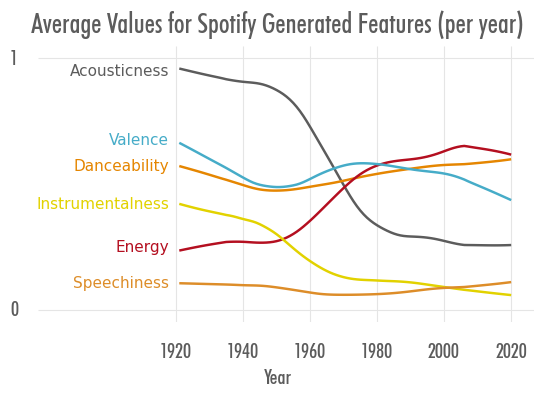

<ggplot: (106570100559)>

In [8]:
(ggplot(data_agg_1) 
 + geom_smooth(aes(x = "yr_num", y = "acousticness"), color=FMF_Palette[0], span=.3, se=False)
 + annotate("text", label="Acousticness", x = 1918.0, y=0.95, color=FMF_Palette[0], ha="right")
 + geom_smooth(aes(x = "yr_num", y = "danceability"), color=FMF_Palette[4], size=1, span=.3, se=False)
 + annotate("text", label="Danceability", x = 1918.0, y=0.57, color=FMF_Palette[4], ha="right" )
 + geom_smooth(aes(x = "yr_num", y = "energy"), color=FMF_Palette[5], span=.3, se=False)
 + annotate("text", label="Energy", x = 1918.0, y=0.25, color=FMF_Palette[5], ha="right" )
 + geom_smooth(aes(x = "yr_num", y = "instrumentalness"), color=FMF_Palette[2], span=.3, se=False)
 + annotate("text", label="Instrumentalness", x = 1918.0, y=0.42, color=FMF_Palette[2], ha="right" )
 + geom_smooth(aes(x = "yr_num", y = "speechiness"), color=FMF_Palette[3], span=.3, se=False)
 + annotate("text", label="Speechiness", x = 1918.0, y=0.105, color=FMF_Palette[3], ha="right" )
 + geom_smooth(aes(x = "yr_num", y = "valence"), color=FMF_Palette[1], span=.3, se=False)
 + annotate("text", label="Valence", x = 1918.0, y=0.675, color=FMF_Palette[1], ha="right" )
 + scale_x_continuous(limits=(1885.5,2020), breaks = range(1920,2021,20))
 + scale_y_continuous(limits=(0,1), breaks=[0,1])
 + theme_minimal()
 + theme(panel_grid_minor=element_blank(), 
         text=element_text(fontproperties=futura, color=FMF_Palette[0], size=15),
         plot_title=element_text(size=20))
 + ggtitle("Average Values for Spotify Generated Features (per year)")
 + labs(x="Year", y="",size=20)
 + coord_fixed(75)
)

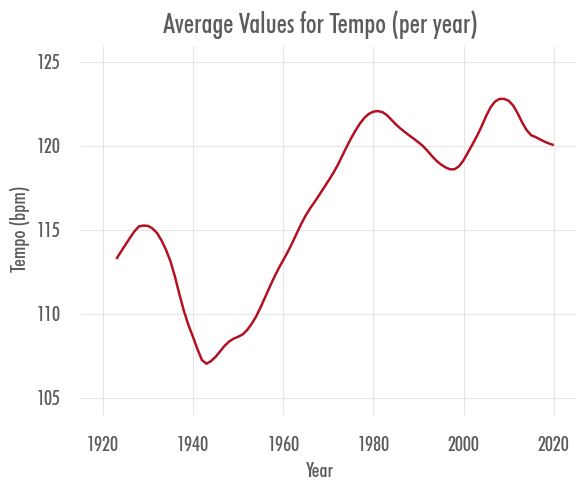

<ggplot: (106570208253)>

In [9]:
(ggplot(data_agg_1) 
 + geom_smooth(aes(x = "yr_num", y = "tempo"), color=FMF_Palette[5], span=.125, se=False)
 + scale_x_continuous(limits=(1920,2020), breaks = range(1920,2021,20))
 + scale_y_continuous(limits=(105,125))
 + theme_minimal()
 + theme(panel_grid_minor=element_blank(),
         text=element_text(fontproperties=futura, color=FMF_Palette[0], size=15),
         plot_title=element_text(size=20))
 + ggtitle("Average Values for Tempo (per year)")
 + labs(x="Year", y="Tempo (bpm)")
)

In [10]:
data_agg_1["duration_min"] = data_agg_1["duration_ms"].div(60000)


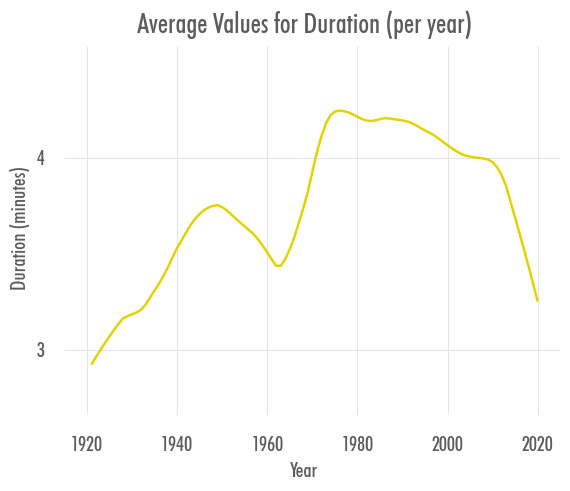

<ggplot: (106570239732)>

In [11]:
(ggplot(data_agg_1) 
 + geom_smooth(aes(x = "yr_num", y = "duration_min"), color=FMF_Palette[2], span=.15, se=False)
 + scale_x_continuous(limits=(1920,2020), breaks = range(1920,2021,20))
 + scale_y_continuous(limits=(2.75,4.5), breaks = [3,4])
 + theme_minimal()
 + theme(panel_grid_minor=element_blank(),
         text=element_text(fontproperties=futura, color=FMF_Palette[0], size=15),
         plot_title=element_text(size=20))
 + ggtitle("Average Values for Duration (per year)")
 + labs(x="Year", y="Duration (minutes)")
)

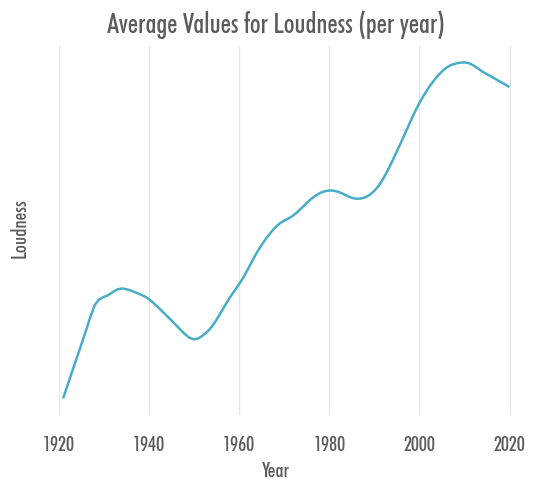

<ggplot: (106570237889)>

In [12]:
(ggplot(data_agg_1) 
 + geom_smooth(aes(x = "yr_num", y = "loudness"), color=FMF_Palette[1], span=.15, se=False)
 + scale_x_continuous(limits=(1920,2020), breaks = range(1920,2021,20))
 + theme_minimal()
 + theme(panel_grid_minor=element_blank(),
         panel_grid_major_y=element_blank(),
         axis_text_y=element_blank(),
         text=element_text(fontproperties=futura, color=FMF_Palette[0], size=15),
         plot_title=element_text(size=20))
 + ggtitle("Average Values for Loudness (per year)")
 + labs(x="Year", y="Loudness")
)

In [13]:
key_distro_1["percentage100"] = key_distro_1["percentage"] * 100

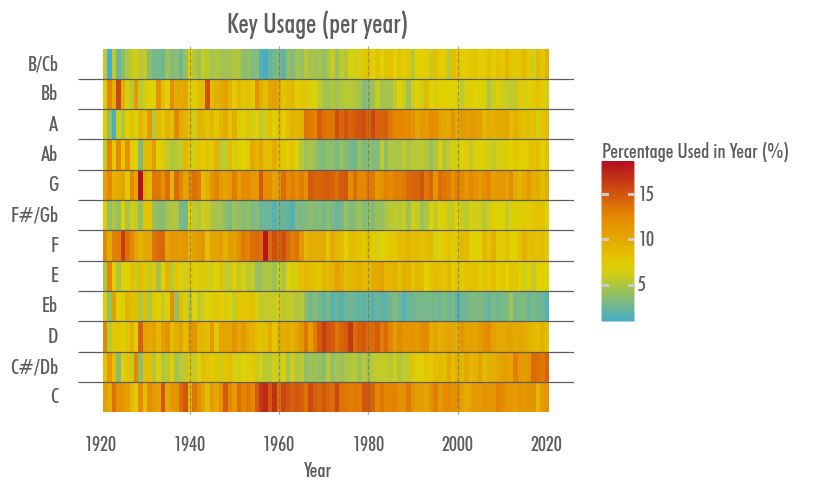

<ggplot: (106570290146)>

In [14]:
FMF_Palette2 = ["#46ACC8","#E2D200", "#E58601", "#B40F20"]
# FMF_Palette.reverse()

(ggplot(key_distro_1, aes(x = "yr_num", y = "key", fill = "percentage100")) 
 + geom_tile()
 + scale_x_continuous(limits=(1920,2021), breaks = range(1920,2021,20))
 + scale_y_discrete(breaks=range(0,12), labels=["C",
                                                "C#/Db",
                                                "D",
                                                "Eb",
                                                "E",
                                                "F",
                                                "F#/Gb",
                                                "G",
                                                "Ab",
                                                "A",
                                                "Bb",
                                                "B/Cb"])
 + geom_vline(xintercept=[1940,1960,1980,2000], linetype="dashed", color="#5C5C5C7F")
 + geom_hline(yintercept=np.array(range(1,12))+.5, color=FMF_Palette[0])
#  + scale_fill_gradientn(["#500660","#05A8AA","#43E000"], name="Percentage Used in Year (%)",)
 + scale_fill_gradientn(FMF_Palette2, name="Percentage Used in Year (%)",)
 + theme_minimal()
 + ggtitle("Key Usage (per year)")
 + labs(x="Year", y="")
 + theme(panel_grid_minor=element_blank(), 
         panel_grid_major=element_blank(),
         text=element_text(fontproperties=futura, color=FMF_Palette[0], size=15),
         plot_title=element_text(size=20))
)

Fewer flat keys most likely because of more guitars

In [15]:
mode_distro_1["percentage100"] = mode_distro_1["percentage"] * 100
mode_distro_1 = mode_distro_1.append(pd.DataFrame({"year": [1921],
                                                           "mode": [0],
                                                           "number": [0],
                                                           "yr_num": [1921.0],
                                                           "percentage100": [0]}))

mode_distro_1.head()

,year,mode,number,percentage,yr_num,percentage100
0,1921,1,80,0.661157,1921.0,66.115702
0,1922,1,45,0.625000,1922.0,62.500000
0,1923,1,131,0.775148,1923.0,77.514793
0,1924,1,178,0.751055,1924.0,75.105485
0,1925,1,189,0.718631,1925.0,71.863118


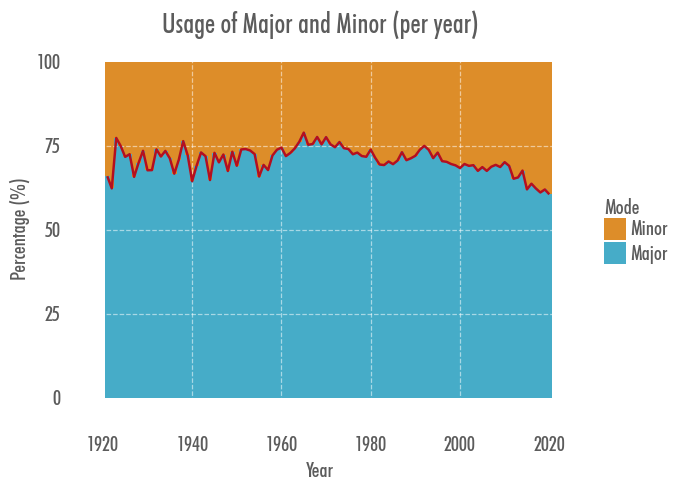

<ggplot: (106570343792)>

In [16]:
(ggplot(mode_distro_1, aes(x = "yr_num", y = "percentage100", fill = "mode")) 
 + geom_rect(xmin=1920.5,xmax=2020.5,ymin=0,ymax=100, fill=FMF_Palette[3])
 + geom_bar(position="stack", stat="identity", width=1)
 + scale_x_continuous(limits=(1920,2021), breaks = range(1920,2021,20))
 + scale_y_continuous(limits=(0,100), breaks=[0,25,50,75,100])
 + scale_fill_manual(name="Mode", labels=["Minor", "Major"], values=[FMF_Palette[3],FMF_Palette[1]])
 + geom_vline(xintercept=[1940,1960,1980,2000], linetype="dashed", color="#ffffff88")
 + geom_hline(yintercept=[25,50,75], linetype="dashed", color="#ffffff88")
 + theme_minimal()
 + theme(panel_grid_minor=element_blank(), 
         panel_grid_major=element_blank(),
         text=element_text(fontproperties=futura, color=FMF_Palette[0], size=15),
         plot_title=element_text(size=20))
 + ggtitle("Usage of Major and Minor (per year)")
 + labs(x="Year", y="Percentage (%)", fill="Explicit?")
 + guides(color = guide_legend(reverse = True))
 + geom_line(aes(x = "yr_num", y = "percentage100"), color=FMF_Palette[5],size=1)
)

In [17]:
explicit_distro_1["percentage100"] = explicit_distro_1["percentage"] * 100
explicit_distro_1 = explicit_distro_1.append(pd.DataFrame({"year": [1921],
                                                           "explicit": [1],
                                                           "number": [0],
                                                           "yr_num": [1921.0],
                                                           "percentage100": [0]}))

explicit_distro_1.head()

,year,explicit,number,percentage,yr_num,percentage100
0,1921,0,121,1.0,1921.0,100.0
0,1922,0,72,1.0,1922.0,100.0
0,1923,0,169,1.0,1923.0,100.0
0,1924,0,237,1.0,1924.0,100.0
0,1925,0,263,1.0,1925.0,100.0


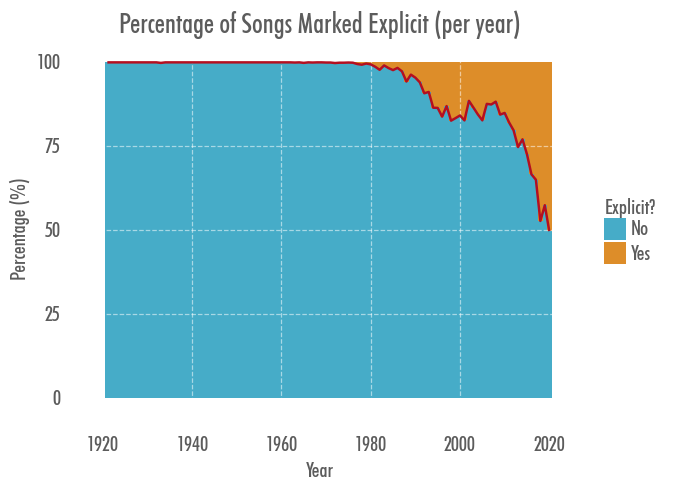

<ggplot: (106570230697)>

In [18]:
(ggplot(explicit_distro_1, aes(x = "yr_num", y = "percentage100", fill = "explicit")) 
 + geom_rect(xmin=1920.5,xmax=2020.5,ymin=0,ymax=100, fill=FMF_Palette[3])
 + geom_bar(position="stack", stat="identity", width=1)
 + scale_x_continuous(limits=(1920,2021), breaks = range(1920,2021,20))
 + scale_y_continuous(limits=(0,100), breaks=[0,25,50,75,100])
 + scale_fill_manual(name="Explicit?", labels=["No", "Yes"], values=[FMF_Palette[1],FMF_Palette[3]])
 + geom_vline(xintercept=[1940,1960,1980,2000], linetype="dashed", color="#ffffff88")
 + geom_hline(yintercept=[25,50,75], linetype="dashed", color="#ffffff88")
 + theme_minimal()
 + theme(panel_grid_minor=element_blank(), 
         panel_grid_major=element_blank(),
         text=element_text(fontproperties=futura, color=FMF_Palette[0], size=15),
         plot_title=element_text(size=20))
 + ggtitle("Percentage of Songs Marked Explicit (per year)")
 + labs(x="Year", y="Percentage (%)", fill="Explicit?")
 + guides(color = guide_legend(reverse = True))
 + geom_line(aes(x = "yr_num", y = "percentage100"), color=FMF_Palette[5],size=1)
)

## 2- Can we predict if a track is major or minor given it's other characteristics?

In [19]:
np.random.seed(11132013)
data_2 = pd.read_csv("../Data/data_modified.csv")
data_2.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,explicit,key,mode,year,name,artists
0,0.995,0.514,172133,0.2560,0.00000,0.3490,-15.145,0,0.0871,79.467,0.574,0,0,1,1921,Si J'avais Su,['Alice Cocéa']
1,0.994,0.426,177733,0.2260,0.00000,0.2350,-16.126,0,0.0693,73.630,0.552,0,9,1,1921,Elle Porte Un Nom Charmant,['André Urban']
2,0.971,0.540,122000,0.0848,0.00196,0.0887,-16.055,0,0.0750,100.296,0.527,0,5,0,1921,A Ballynure Ballad,['Christopher Lynch']
3,0.950,0.607,163200,0.1380,0.00000,0.1140,-15.683,0,0.1570,113.282,0.511,0,3,1,1921,I Met Her In The Garden Where The Praties Grow,['Christopher Lynch']
4,0.969,0.344,120067,0.1310,0.00000,0.1450,-14.261,0,0.0616,178.212,0.257,0,10,0,1921,Just A Little Bit Of Heaven,['Christopher Lynch']


**Data will be standardized so LASSO will work**

In [20]:
features_2 = ["acousticness",
              "danceability",
              "duration_ms",
              "energy",
              "instrumentalness",
              "loudness",
              "speechiness",
              "tempo",
              "valence",
              "explicit"]
X_2 = data_2[features_2]
y_2 = data_2[["mode"]]

In [21]:
## AGGREGATE DATA FOR MODES ##

z_total_2 = StandardScaler()
Xz_total_2 = z_total_2.fit_transform(X_2)

data_z_total_2 = pd.DataFrame({})
data_z_total_2["mode"] = y_2["mode"]

i_2 = 0
for name in features_2:
    data_z_total_2[name] = Xz_total_2[:,i_2]
    i_2 = i_2 + 1
    
data_z_mode_0_2 = data_z_total_2.loc[data_z_total_2["mode"] == 0]
data_z_mode_1_2 = data_z_total_2.loc[data_z_total_2["mode"] == 1]

data_z_mode_agg_2 = pd.DataFrame({})
data_z_mode_agg_2["mode"] = [0,1]

for name in features_2:
    data_z_mode_agg_2[name] = [data_z_mode_0_2[name].mean(),data_z_mode_1_2[name].mean()]
    
data_z_mode_agg_2.head()

,mode,acousticness,danceability,duration_ms,energy,instrumentalness,loudness,speechiness,tempo,valence,explicit
0,0,-0.072352,0.068753,0.077513,0.064708,0.056706,0.024440,0.091361,-0.022580,-0.024198,0.129679
1,1,0.029630,-0.028157,-0.031744,-0.026500,-0.023223,-0.010009,-0.037415,0.009247,0.009910,-0.053108


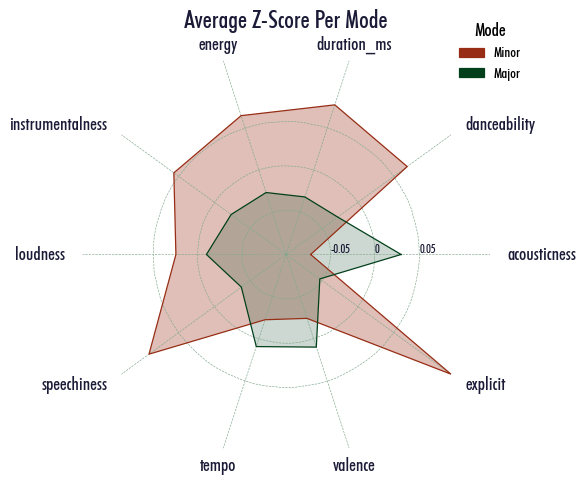

In [22]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

## BUUILD RADAR GRAPH FOR MODES ##

figure(num=None, figsize=(6,6), dpi=90, facecolor='w', edgecolor='k')

# number of variable
N_2 = len(features_2)

# Extract values for minor mode
# repeat the first value to close the circular graph:
values_minor_2=data_z_mode_agg_2.loc[0].drop('mode').values.flatten().tolist()
values_minor_2 += values_minor_2[:1]

# Extract values for major mode
# repeat the first value to close the circular graph:
values_major_2=data_z_mode_agg_2.loc[1].drop('mode').values.flatten().tolist()
values_major_2 += values_major_2[:1]

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles_2 = [n / float(N_2) * 2 * pi for n in range(N_2)]
angles_2 += angles_2[:1]

# Initialise the spider plot
ax_2 = plt.subplot(111, polar=True)
plt.grid(which='both',color=Cav_Palette[3], linestyle='dashed', linewidth=.5)
plt.grid(which='both',axis='y', sketch_params=0.2)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles_2[:-1], features_2, color=Cav_Palette[5])
for label in ax_2.get_xticklabels():
    label.set_fontproperties(futura)
    label.set_size(15)
    if label.get_position()[0] < 1.2 or label.get_position()[0] > 5.5:
        label.set_ha('left')
    elif 1.9 < label.get_position()[0] < 3.8:
        label.set_ha('right')

# Draw ylabels
ax_2.set_rlabel_position(0)
plt.yticks([-.05,0,.05], ["-0.05","0","0.05"], color=Cav_Palette[5])
plt.ylim(-.1,.13)
for label in ax_2.get_yticklabels():
    label.set_fontproperties(futura)
    label.set_size(10)


# Plot data and Fill area for minor
ax_2.plot(angles_2, values_minor_2, Cav_Palette[4], linewidth=1, linestyle='solid')
ax_2.fill(angles_2, values_minor_2, Cav_Palette[4], alpha=0.3)

# Plot data and Fill area for major
ax_2.plot(angles_2, values_major_2, Cav_Palette[1], linewidth=1, linestyle='solid')
ax_2.fill(angles_2, values_major_2, Cav_Palette[1], alpha=0.2)

minor_patch_2 = mpatches.Patch(color=Cav_Palette[4], label='Minor')
major_patch_2 = mpatches.Patch(color=Cav_Palette[1], label='Major')
ax_2.legend(handles=[minor_patch_2, major_patch_2],
            title="Mode",
            bbox_to_anchor=(1, 1),
            loc='center',
            framealpha=0)
ax_2.legend_.get_title().set_fontproperties(futura)
ax_2.legend_.get_title().set_fontsize(15)
for label in ax_2.legend_.get_texts():
    label.set_fontproperties(futura)
    label.set_fontsize(12)

# ax_2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title("Average Z-Score Per Mode", fontproperties=futura, size=20, color=Cav_Palette[5])

ax_2.spines["polar"].set_visible(False)

In [23]:
coef_names_2 = ["pass", "score"] + features_2 + ["intercept"] #Score will be a simple accuracy percentage
coefs_each_pass_2 = pd.DataFrame(columns=coef_names_2)
coefs_each_pass_2.head()

lr_2 = LogisticRegression(penalty='l1', solver='liblinear')
kf_2 = KFold(n_splits = 10, shuffle=True, random_state=1645)

# Steps:
# 1- Run K-fold
#    a) generate model with L1 penalty
#    b) calculate model effectiveness
#    c) put coefs and score in coef_names_2
# 2- Calculate optimal coefs
# 3- Reverse-transform coefs
# 4- Calculate overall score
# 5- Make confusion matrix

pass_indx_2 = 0
for train,test in kf_2.split(Xz_total_2):
    X_train = data_z_total_2[features_2].iloc[train]
    X_test = data_z_total_2[features_2].iloc[test]
    y_train = data_z_total_2[["mode"]].iloc[train]
    y_test = data_z_total_2[["mode"]].iloc[test]
    
    lr_temp = LogisticRegression(penalty='l1', solver='liblinear', C=.01)
    lr_temp.fit(X_train, y_train)
    
    results_dict_temp = {'pass':pass_indx_2,
                         'score': accuracy_score(y_test, lr_temp.predict(X_test))}
    
    feat_indx = 0
    for name in features_2:
        results_dict_temp[name] = lr_temp.coef_.flatten()[feat_indx]
        feat_indx = feat_indx + 1
    
    results_dict_temp['intercept'] = lr_temp.intercept_
    
    coefs_each_pass_2 = coefs_each_pass_2.append(results_dict_temp, ignore_index=True)
    
    pass_indx_2 = pass_indx_2 + 1
    print(lr_temp.coef_.shape)
coefs_each_pass_2.head(10)

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


,pass,score,acousticness,danceability,duration_ms,energy,instrumentalness,loudness,speechiness,tempo,valence,explicit,intercept
0,0,0.704308,0.027505,-0.124474,-0.082717,-0.119964,-0.136197,0.040519,-0.074545,0.028460,0.085607,-0.108843,[0.9060683569048549]
1,1,0.707824,0.025157,-0.130700,-0.082777,-0.126732,-0.134386,0.047952,-0.069740,0.026465,0.091142,-0.113186,[0.9043392048495208]
2,2,0.714618,0.022992,-0.125151,-0.082973,-0.127673,-0.135014,0.046322,-0.076369,0.025502,0.087216,-0.116018,[0.900390628686821]
3,3,0.707646,0.025602,-0.129187,-0.084664,-0.123210,-0.137844,0.045662,-0.074251,0.021359,0.088627,-0.112719,[0.9044034221648599]
4,4,0.707407,0.033470,-0.126858,-0.086958,-0.120005,-0.131321,0.046726,-0.075446,0.026011,0.087570,-0.111774,[0.9046956544210332]
5,5,0.707407,0.029757,-0.128881,-0.083005,-0.124912,-0.134398,0.048828,-0.075103,0.024900,0.088758,-0.113683,[0.904963832427577]
6,6,0.711204,0.022023,-0.130898,-0.081881,-0.125886,-0.137082,0.040586,-0.073728,0.024528,0.088309,-0.110407,[0.9019335097334965]
7,7,0.711800,0.022366,-0.127525,-0.081605,-0.126257,-0.135907,0.041117,-0.072519,0.024540,0.091817,-0.110155,[0.9014118445709763]
8,8,0.704052,0.021563,-0.125260,-0.084102,-0.128993,-0.131428,0.046011,-0.075154,0.029075,0.091146,-0.112695,[0.9064694334035388]
9,9,0.711859,0.025015,-0.127687,-0.082330,-0.125000,-0.138437,0.040980,-0.075162,0.028234,0.090995,-0.111274,[0.9020443541472778]


True coefs will be median of all trials

In [24]:
print("Avg score: " + str(coefs_each_pass_2['score'].mean()))

Avg score: 0.7088125791989479


In [25]:
## Simple function to return a list of rgb tuples from list of hex codes ##
def hex_to_rgb(values):
    rgbList = []
    for value in values:
        temp = value.lstrip('#')
        length = len(temp)
        rgbList.append(tuple(int(temp[i:i + length // 3], 16)/255.0 for i in range(0, length, length // 3)))
    return(rgbList)

0.7088065980954197
[[Text(0, 0, '154') Text(1, 0, '48601')]
 [Text(0, 1, '263') Text(1, 1, '118788')]]


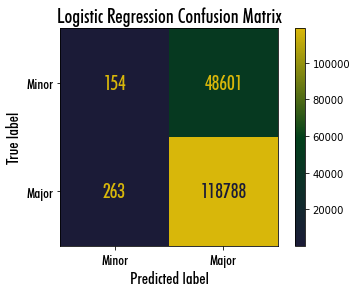

In [26]:
lr_2.coef_ = np.ndarray(shape=(1,10))

indx_2 = 0
for name in features_2:
    lr_2.coef_[0,indx_2] = coefs_each_pass_2[name].median()
    indx_2 = indx_2 + 1


lr_2.intercept_ = coefs_each_pass_2['intercept'].median()
lr_2.classes_ = np.array([0, 1])
pred_2 = lr_2.predict(Xz_total_2)

print(accuracy_score(y_2, pred_2))
con_matrix_2 = plot_confusion_matrix(lr_2, Xz_total_2, y_2,
                   display_labels=["Minor", "Major"],
                   cmap=LinearSegmentedColormap.from_list(name='temp', 
                       colors=hex_to_rgb([Cav_Palette[5],
                                          Cav_Palette[1],
                                          Cav_Palette[0]])))

con_matrix_2.ax_.set_title("Logistic Regression Confusion Matrix", fontproperties=futura, size=20)
con_matrix_2.ax_.tick_params(axis='both', which='major', labelsize=15)

con_matrix_2.ax_.set_xlabel('Predicted label', fontsize=17, fontproperties=futura)
# con_matrix_2.ax_.get_xlabel().set_size(15)

con_matrix_2.ax_.set_ylabel('True label', fontsize=17, fontproperties=futura)
# con_matrix_2.ax_.get_ylabel().set_size(15)

for label in con_matrix_2.ax_.get_yticklabels() + con_matrix_2.ax_.get_xticklabels():
    label.set_fontproperties(futura)
    label.set_size(15)
for temp in con_matrix_2.text_:
    for text in temp:
        text.set_fontproperties(futura)
        text.set_size(20)

print(con_matrix_2.text_)

## 3- Can we classify the songs into different "contexts" in which they would be played?

Departure from original plan because dataset too big for HAC and dendrograms

In [27]:
data_3 = pd.read_csv("../Data/data_modified.csv")
data_3.dropna(inplace=True)
data_3.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,explicit,key,mode,year,name,artists
0,0.995,0.514,172133,0.2560,0.00000,0.3490,-15.145,0,0.0871,79.467,0.574,0,0,1,1921,Si J'avais Su,['Alice Cocéa']
1,0.994,0.426,177733,0.2260,0.00000,0.2350,-16.126,0,0.0693,73.630,0.552,0,9,1,1921,Elle Porte Un Nom Charmant,['André Urban']
2,0.971,0.540,122000,0.0848,0.00196,0.0887,-16.055,0,0.0750,100.296,0.527,0,5,0,1921,A Ballynure Ballad,['Christopher Lynch']
3,0.950,0.607,163200,0.1380,0.00000,0.1140,-15.683,0,0.1570,113.282,0.511,0,3,1,1921,I Met Her In The Garden Where The Praties Grow,['Christopher Lynch']
4,0.969,0.344,120067,0.1310,0.00000,0.1450,-14.261,0,0.0616,178.212,0.257,0,10,0,1921,Just A Little Bit Of Heaven,['Christopher Lynch']


In [28]:
features_3 = ["acousticness",
              "danceability",
              "energy",
              "instrumentalness",
              "loudness",
              "speechiness",
              "tempo",
              "valence",
              "explicit",
              "mode"]

data_3[features_3] = StandardScaler().fit_transform(data_3[features_3])

data_3[features_3].head()

,acousticness,danceability,energy,instrumentalness,loudness,speechiness,tempo,valence,explicit,mode
0,1.323086,-0.127024,-0.884465,-0.527539,-0.686569,0.025545,-1.223101,0.161090,-0.281784,0.639946
1,1.320436,-0.628447,-0.996881,-0.527539,-0.860778,-0.123006,-1.413196,0.077607,-0.281784,0.639946
2,1.259473,0.021123,-1.525984,-0.521231,-0.848170,-0.075436,-0.544761,-0.017260,-0.281784,-1.562633
3,1.203811,0.402888,-1.326633,-0.527539,-0.782109,0.608901,-0.121844,-0.077975,-0.281784,0.639946
4,1.254172,-1.095682,-1.352864,-0.527539,-0.529585,-0.187267,1.992740,-1.041822,-0.281784,-1.562633


In [29]:
# dendro_sing = sch.dendrogram(sch.linkage(data_3[features_3], method = 'ward'))
# MemoryError: Unable to allocate 105. GiB for an array with shape (14079342915,) and data type float64

In [31]:
pca_3 = PCA()
pca_3.fit(data_3[features_3])

PCA()

In [32]:
pcaDF_3 = pd.DataFrame({"expl_var" : pca_3.explained_variance_ratio_,
                      "pc": range(1,len(features_3)+1),
                      "cum_var": pca_3.explained_variance_ratio_.cumsum()})
pcaDF_3.head()

,expl_var,pc,cum_var
0,0.321866,1,0.321866
1,0.134997,2,0.456863
2,0.120541,3,0.577404
3,0.098306,4,0.675710
4,0.092807,5,0.768517


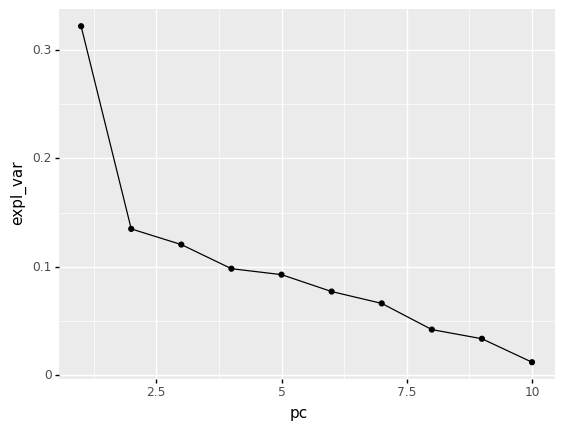

<ggplot: (106571555247)>

In [33]:
ggplot(pcaDF_3, aes(x = "pc", y = "expl_var")) + geom_line() + geom_point()

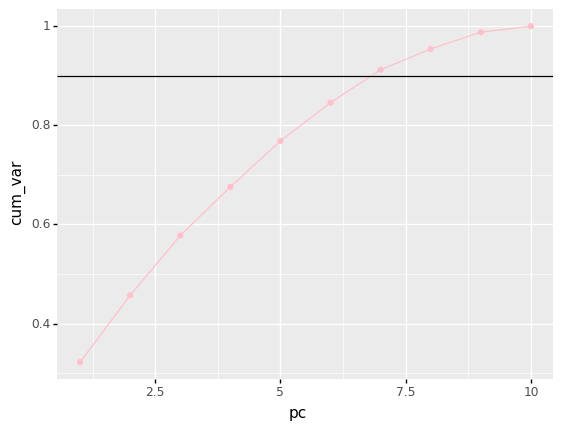

<ggplot: (106585879354)>

In [34]:
(ggplot(pcaDF_3, aes(x = "pc", y = "cum_var")) + geom_line(color = "pink") +
 geom_point(color = "pink") + geom_hline(yintercept = 0.9))

In [35]:
loadings_3 = pd.DataFrame({"loading": pca_3.components_.flatten(),
                         "comp": np.repeat(range(1,len(features_3)+1), len(features_3), axis=0),
                         "variable":np.tile(features_3,len(features_3)) })

loadings_3['loading_abs'] = loadings_3['loading'].abs()
loadings_3.head(70)

,loading,comp,variable,loading_abs
0,0.437747,1,acousticness,0.437747
1,-0.311411,1,danceability,0.311411
2,-0.478315,1,energy,0.478315
3,0.309514,1,instrumentalness,0.309514
4,-0.467253,1,loudness,0.467253
5,-0.082979,1,speechiness,0.082979
6,-0.180206,1,tempo,0.180206
7,-0.299201,1,valence,0.299201
8,-0.196934,1,explicit,0.196934
9,0.028761,1,mode,0.028761


In [36]:
# loadings_3.to_csv('pca_loadings_3.csv', index=False)

### Naming Principle Components

1. **Calmness**
    - High in:
        - energy (negative)
        - loudness (negative)
        - acousticness (positive)
<br><br>
1. **Rappiness**
    - High in:
        - speechiness (positive)
        - danceability (positive)
        - explicit (positive)
<br><br>
1. **Edginess**
    - High in:
        - valence (negative)
        - explicit (positive)
<br><br>
1. **Mode**
    - High in:
        - mode (positive)
<br><br>
1. **Tempo**
    - High in:
        - tempo (positive)
<br><br>
1. **Instrumentalness**
    - High in:
        - instrumentalness (positive)
<br><br>
1. **Speechiness**
    - High in:
        - speechiness (positive)

In [37]:
pc_names_3 = ['pc_calmness',
              'pc_rappiness',
              'pc_edginess',
              'pc_mode',
              'pc_tempo',
              'pc_instrumentalness',
              'pc_speechiness']

pc_comps_7_3 = pca_3.transform(data_3[features_3])

for i_3 in range(0,len(pc_names_3)):
    data_3[pc_names_3[i_3]] = pc_comps_7_3[:,i_3]

data_3[pc_names_3] = StandardScaler().fit_transform(data_3[pc_names_3])
data_3.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,...,year,name,artists,pc_calmness,pc_rappiness,pc_edginess,pc_mode,pc_tempo,pc_instrumentalness,pc_speechiness
0,1.323086,-0.127024,172133,-0.884465,-0.527539,0.3490,-0.686569,0,0.025545,-1.223101,...,1921,Si J'avais Su,['Alice Cocéa'],0.804485,0.615476,-0.783876,0.761558,-0.864348,-0.622119,-0.127392
1,1.320436,-0.628447,177733,-0.996881,-0.527539,0.2350,-0.860778,0,-0.123006,-1.413196,...,1921,Elle Porte Un Nom Charmant,['André Urban'],1.006105,0.425384,-0.603227,0.804349,-1.010193,-0.684703,-0.096013
2,1.259473,0.021123,122000,-1.525984,-0.521231,0.0887,-0.848170,0,-0.075436,-0.544761,...,1921,A Ballynure Ballad,['Christopher Lynch'],0.908429,0.934716,-0.215293,-1.184208,-0.305217,-1.560123,-0.782756
3,1.203811,0.402888,163200,-1.326633,-0.527539,0.1140,-0.782109,0,0.608901,-0.121844,...,1921,I Met Her In The Garden Where The Praties Grow,['Christopher Lynch'],0.728442,0.913777,-0.805287,0.863018,0.306618,-0.867981,-0.317512
4,1.254172,-1.095682,120067,-1.352864,-0.527539,0.1450,-0.529585,0,-0.187267,1.992740,...,1921,Just A Little Bit Of Heaven,['Christopher Lynch'],0.891932,-0.412555,0.709240,-1.023930,1.947709,-2.105982,-1.328758


In [38]:
# data_3.to_csv('data_pca_3.csv', index=False)

In [119]:
X_3 = data_3[pc_names_3]

k_best_GM_3 = 4 #obtained by running code below
max_silhouette_gm_3 = 0


# for i in range(2,10):
#     print("Testing k=" + str(i))
#     km_test = KMeans(n_clusters=i)
    
#     km_test.fit(X_3)
#     tempAssignment = km_test.predict(X_3)

#     sil_test = silhouette_score(X_3, tempAssignment, sample_size=25000)

#     if sil_test > max_silhouette_km_3:
#         k_best_KM_3 = i
#         max_silhouette_km_3 = sil_test
    
#     print(str(i) + ":  " + str(sil_test))

gm_best_3 = GaussianMixture(n_components=k_best_GM_3)
gm_best_3.fit(X_3)
data_3["GM_Cat"] = gm_best_3.predict(X_3)

# max_silhouette_km_3 = silhouette_score(X_3, data_3["KM_Cat"], sample_size=25000)
print("The optimal number of groups is: k=" + str(k_best_GM_3))
# print("The silhouette Score for that many groups is:  " + str(max_silhouette_km_3))
print()



for i in range(0, k_best_GM_3):
    print("Average Scores for Cluster " + str(i))
    inGroup = data_3['GM_Cat'] == i
    dataCat = data_3.loc[inGroup]

    for name in pc_names_3:
        avg = dataCat[name].mean()

        print("\t" + name + ": " + str(avg))
    print()

The optimal number of groups is: k=4

Average Scores for Cluster 0
	pc_calmness: 0.865787513985593
	pc_rappiness: -0.11199151840746639
	pc_edginess: 0.029891152497173227
	pc_mode: -0.44864842857800447
	pc_tempo: 0.19508650826867557
	pc_instrumentalness: 0.9766347236359881
	pc_speechiness: 0.26907583820591496

Average Scores for Cluster 1
	pc_calmness: -0.13779681219157563
	pc_rappiness: -0.3032158181356613
	pc_edginess: -0.26285098613119723
	pc_mode: 0.08368203541916518
	pc_tempo: -0.23350744251322697
	pc_instrumentalness: -0.47493752633254416
	pc_speechiness: -0.16511689838565127

Average Scores for Cluster 2
	pc_calmness: -0.47681735816141485
	pc_rappiness: 0.5931349073071691
	pc_edginess: -0.07906675155974198
	pc_mode: 0.1864725786234112
	pc_tempo: 0.5333363407253778
	pc_instrumentalness: -0.6078347569693434
	pc_speechiness: 1.110126805046153

Average Scores for Cluster 3
	pc_calmness: -1.2538395551847707
	pc_rappiness: 1.5873529735281744
	pc_edginess: 1.9495780489139847
	pc_mode: 0

In [127]:
data_3[['name','artists','year','popularity','GM_Cat']].to_csv('gm_clusters_3.csv', index=False)

(12585, 26)


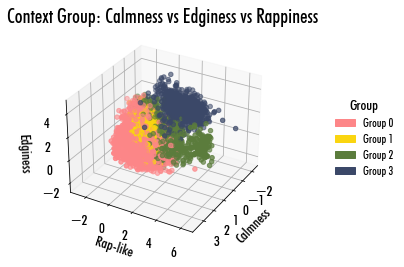

In [125]:
data_sub_3 = data_3.sample(frac=0.075, random_state = 623)
print(data_sub_3.shape)

fig_3 = plt.figure()
ax_3 = fig_3.add_subplot(111, projection='3d')

ax_3.set_title("Context Group: Calmness vs Edginess vs Rappiness",fontproperties=futura, size=20)

ax_3.scatter(data_sub_3['pc_calmness'],
           data_sub_3['pc_rappiness'], 
           data_sub_3['pc_edginess'], 
           c=data_sub_3['GM_Cat'],
           cmap=LinearSegmentedColormap.from_list(name='temp', 
                       colors=hex_to_rgb([BRk_Palette[0],
                                          BRk_Palette[2],
                                          BRk_Palette[3],
                                          BRk_Palette[4]])))

ax_3.set_xlabel('Calmness',fontproperties=futura, size=15)
ax_3.set_ylabel('Rap-like',fontproperties=futura, size=15)
ax_3.set_zlabel('Edginess',fontproperties=futura, size=15)

for label in ax_3.get_xticklabels():
    label.set_fontproperties(futura)
    label.set_size(15)
for label in ax_3.get_yticklabels():
    label.set_fontproperties(futura)
    label.set_size(15)
for label in ax_3.get_zticklabels():
    label.set_fontproperties(futura)
    label.set_size(15)

group_0_patch_3 = mpatches.Patch(color=BRk_Palette[0], label='Group 0')
group_1_patch_3 = mpatches.Patch(color=BRk_Palette[2], label='Group 1')
group_2_patch_3 = mpatches.Patch(color=BRk_Palette[3], label='Group 2')
group_3_patch_3 = mpatches.Patch(color=BRk_Palette[4], label='Group 3')


lgd_3 = ax_3.legend(handles=[group_0_patch_3,
                     group_1_patch_3,
                     group_2_patch_3,
                     group_3_patch_3],
            title="Group",
            bbox_to_anchor=(1.25, .5),
            loc='center left',
            framealpha=0)
ax_3.legend_.get_title().set_fontproperties(futura)
ax_3.legend_.get_title().set_fontsize(15)
for label in ax_3.legend_.get_texts():
    label.set_fontproperties(futura)
    label.set_fontsize(12)

for angle in range(0,360,2):
    ax_3.view_init(30*np.cos(4*pi*(angle/180.0)), angle)
    plt.savefig('rotatingPlot/'+str(angle)+'clusters.png',
                bbox_extra_artists=(lgd_3,),
                bbox_inches='tight')

ax_3.view_init(30, 30)
plt.show()



In [101]:
np.cos(pi)

-1.0